### Import libraries

In [ ]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [ ]:
train_data = pd.DataFrame(np.load("training_data.npy")) #48000 time series of length 2776
train_data = train_data.astype(np.float32)
valid_periods = pd.DataFrame(np.load("valid_periods.npy"))
categories = pd.DataFrame(np.load("categories.npy"),columns=['Category']) #contains category of the series: {'A', 'B', 'C', 'D', 'E', 'F'}.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float32(2776)
memory usage: 508.3 MB


In [ ]:
train_data.head(2000)

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.725000,0.725000,0.725000,0.725000,0.725000,0.725000,0.675000,0.625000,0.650000,0.650000
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.590909,0.613636,0.568182,0.409091,0.238636,0.318182,0.522727,0.488636,0.602273,0.579545
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.558824,0.573529,0.455882,0.220588,0.000000,0.117647,0.455882,0.411765,0.573529,0.558824
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.604167,0.687500,0.708333,0.520833,0.250000,0.312500,0.479167,0.645833,0.625000,0.625000


In [ ]:
# We want to take from the dataset all the possible sequences of length 'length' belonging to the interval selected by valid periods.

def create_sequences(train_data, valid_periods, categories, length, stride):
    sequences = []
    sequence_categories = []

    for i, (start, end) in enumerate(valid_periods):
        # Ensure the end index doesn't exceed the sequence length
        end = min(end, len(train_data[i]))

        # Generate subsequences for each valid period
        for j in range(start, end - length + 1, stride):
            sequences.append(train_data[i][j:j + length])
            sequence_categories.append(categories[i])

    return sequences, sequence_categories

length = 209
stride = 9  # Change this as needed
train, cat = create_sequences(train_data, valid_periods, categories, length, stride)
train = np.array(train)
cat = np.array(cat)

In [ ]:
np.save('/content/drive/MyDrive/ANN/Homework2/train.npy', train)
np.save('/content/drive/MyDrive/ANN/Homework2/cat.npy', cat)

In [ ]:
cat=pd.DataFrame(cat, columns=['Category'])
train = pd.DataFrame(train)

In [ ]:
del train_data
del categories
train_data = pd.DataFrame(np.load("train.npy"))
categories = pd.DataFrame(np.load("cat.npy", allow_pickle=True), columns=['Category'])

In [ ]:
import numpy as np

# Constants
THRESHOLD = 0.01
LENGTH = train_data.shape[1]  # Assuming LENGTH is the number of columns in train_data

# Compute the number of zeros per row
zeros_per_row = (train_data == 0).sum(axis=1)
max_zeros_per_row = int(round(THRESHOLD * LENGTH))
rows_to_keep = zeros_per_row <= max_zeros_per_row

# Information display
num_of_zeros = np.count_nonzero(rows_to_keep == 0)
size = train_data.shape[0]
print(f"There are {num_of_zeros} out of {size} rows that have at least {max_zeros_per_row} zeros ({round(THRESHOLD*100, 1)}%)")
print(f"The maximum number of zeros in a single row is {np.max(zeros_per_row)} out of {LENGTH} samples")
print(f"Training data size: {size} - {num_of_zeros} = {size - num_of_zeros}")

# Show categories of rows with too many zeros
print("\nRows with too many zeros come from the following categories:")
print(cat[~rows_to_keep])

# Eliminate rows with too many zeros
train_data = train_data[rows_to_keep]
cat = cat[rows_to_keep]


There are 3264 out of 267676 rows that have at least 2 zeros (1.0%)
The maximum number of zeros in a single row is 155 out of 209 samples
Training data size: 267676 - 3264 = 264412

Rows with too many zeros come from the following categories:
['D' 'D' 'D' ... 'F' 'F' 'F']


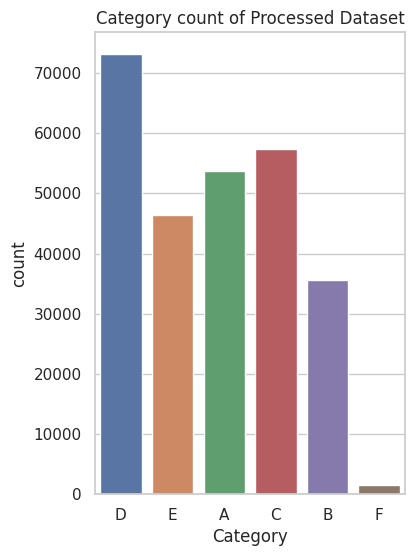

In [ ]:
# Inspect the categories of the new dataset

sns.set(style="whitegrid")
plt.figure(figsize=(4, 6))
sns.countplot(x='Category', data=categories)
plt.title('Category count of Processed Dataset')
plt.show()

In [ ]:
subset_A = categories[categories['Category'] == 'A'].index
subset_B = categories[categories['Category'] == 'B'].index
subset_C = categories[categories['Category'] == 'C'].index
subset_D = categories[categories['Category'] == 'D'].index
subset_E = categories[categories['Category'] == 'E'].index
subset_F = categories[categories['Category'] == 'F'].index
print(f"Shape di subset_A: {len(subset_A)}")
print(f"Shape di subset_B: {len(subset_B)}")
print(f"Shape di subset_C: {len(subset_C)}")
print(f"Shape di subset_D: {len(subset_D)}")
print(f"Shape di subset_E: {len(subset_E)}")
print(f"Shape di subset_F: {len(subset_F)}")

Shape di subset_A: 53772
Shape di subset_B: 35572
Shape di subset_C: 57346
Shape di subset_D: 73128
Shape di subset_E: 46377
Shape di subset_F: 1481


In [ ]:
# Checking if everything worked
categories.iloc[subset_B,:].head(10)

,Category
230623,B
230624,B
230625,B
230626,B
230627,B
230628,B
230629,B
230630,B
230631,B
230632,B


In [ ]:
# Mixing the categories so that the model will be as much general as possible.

categories_new = np.copy(categories)
train_data_new = np.copy(train_data)
a, b, c, d, e, f = 0, 0, 0, 0, 0, 0
i = 0

while (a < len(subset_A)) or (b < len(subset_B)) or (c < len(subset_C)) or (d < len(subset_D)) or (e < len(subset_E)) or (f < len(subset_F)):
    if a < len(subset_A):
        categories_new[i, :] = 'A'
        train_data_new[i,:] = train_data.iloc[subset_A[a],:]
        a = a + 1
        i = i + 1
    if b < len(subset_B):
        categories_new[i, :] = 'B'
        train_data_new[i,:] = train_data.iloc[subset_B[b],:]
        b = b + 1
        i = i + 1
    if c < len(subset_C):
        categories_new[i, :] = 'C'
        train_data_new[i,:] = train_data.iloc[subset_C[c],:]
        c = c + 1
        i = i + 1
    if d < len(subset_D):
        categories_new[i, :] = 'D'
        train_data_new[i,:] = train_data.iloc[subset_D[d],:]
        d = d + 1
        i = i + 1
    if e < len(subset_E):
        categories_new[i, :] = 'E'
        train_data_new[i,:] = train_data.iloc[subset_E[e],:]
        e = e + 1
        i = i + 1
    if f < len(subset_F):
        categories_new[i, :] = 'F'
        train_data_new[i,:] = train_data.iloc[subset_F[f],:]
        f = f + 1
        i = i + 1
categories_new = pd.DataFrame(categories_new, columns=['Category'])
train_data_new = pd.DataFrame(train_data_new)
i

267676

In [ ]:
categories_new.head(10)

,Category
0,A
1,B
2,C
3,D
4,E
5,F
6,A
7,B
8,C
9,D


In [ ]:
np.save('/content/drive/MyDrive/ANN/Homework2/train2.npy', train_data_new)
np.save('/content/drive/MyDrive/ANN/Homework2/cat2.npy', categories_new)